Part 1

The expression matrix has 23870 genes and 94 samples.
The dataset includes 23800 unique genes.


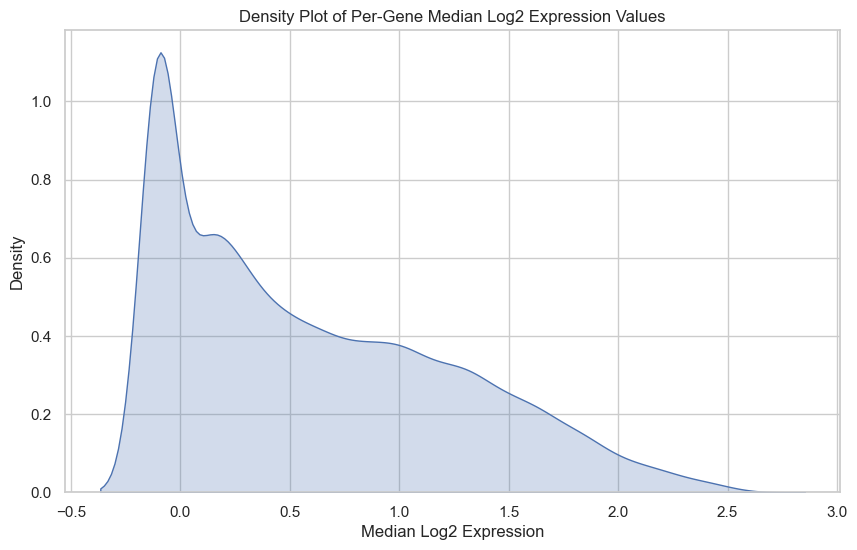

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from gprofiler import GProfiler

#1
# load data into python
df = pd.read_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/data_with_gene_names.tsv', sep='\t')

# check size of expression matrix
# just checking how big this matrix is - number of genes and samples
num_genes, num_samples = df.shape
print(f"The expression matrix has {num_genes} genes and {num_samples - 1} samples.")

# get number of unique genes included
num_unique_genes = df['Gene'].nunique()
print(f"The dataset includes {num_unique_genes} unique genes.")

# normalize the expression data
# dropping 'Gene' column and applying log2 transformation for normalization
expression_data = df.drop('Gene', axis=1)
log_expression_data = np.log2(expression_data + 1)

# calculate median expression
# this shows how much variation each gene has across samples
median_expression = log_expression_data.median(axis=1)

# plotting density plot for per-gene variation
sns.set_theme(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.kdeplot(median_expression, fill=True)

plt.title('Density Plot of Per-Gene Median Log2 Expression Values')
plt.xlabel('Median Log2 Expression')
plt.ylabel('Density')

# displaying the plot
plt.show()


Part 2

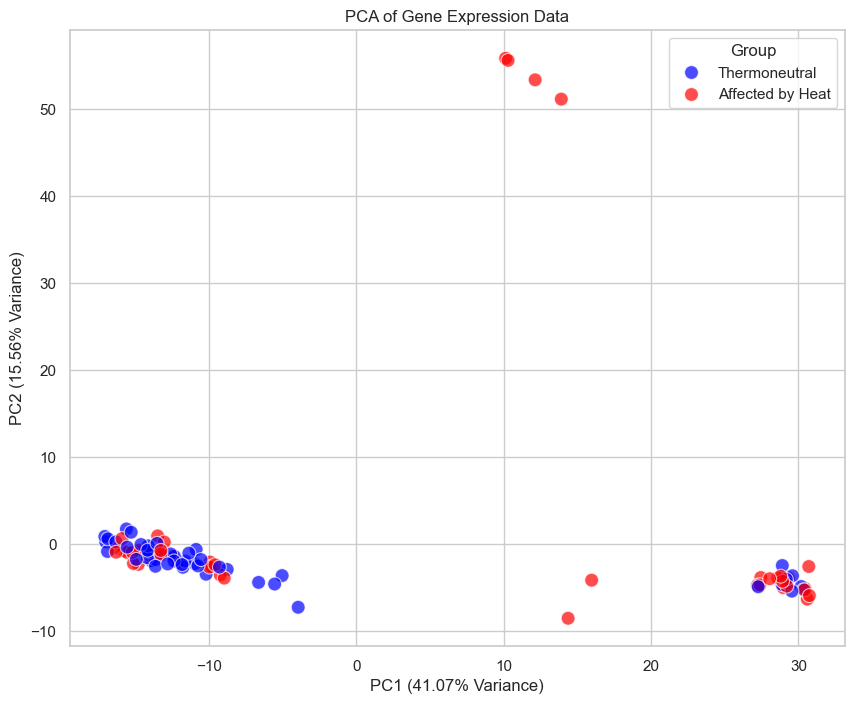

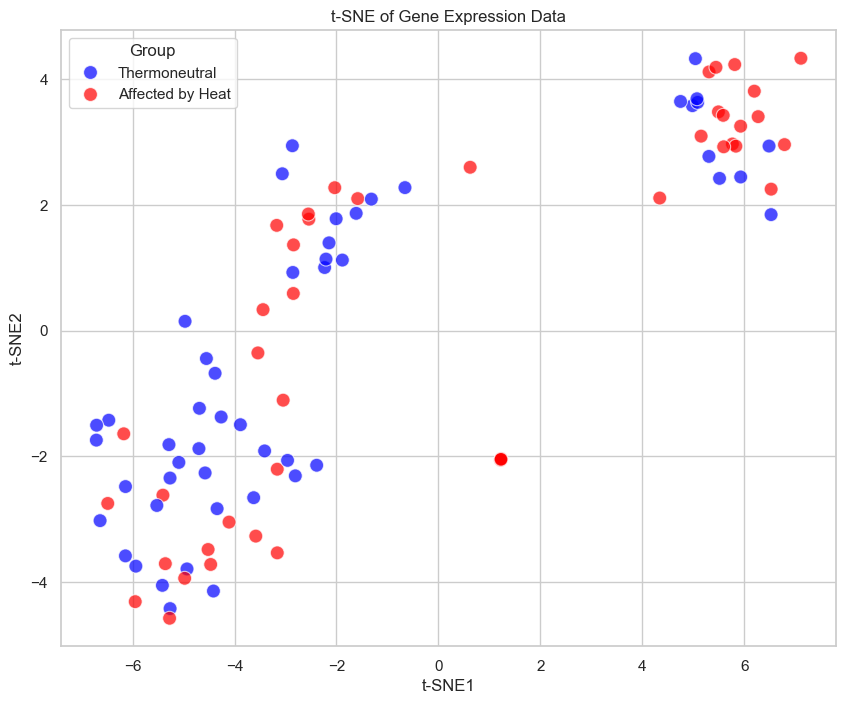

/Users/lukeunbehagen/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lukeunbehagen/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


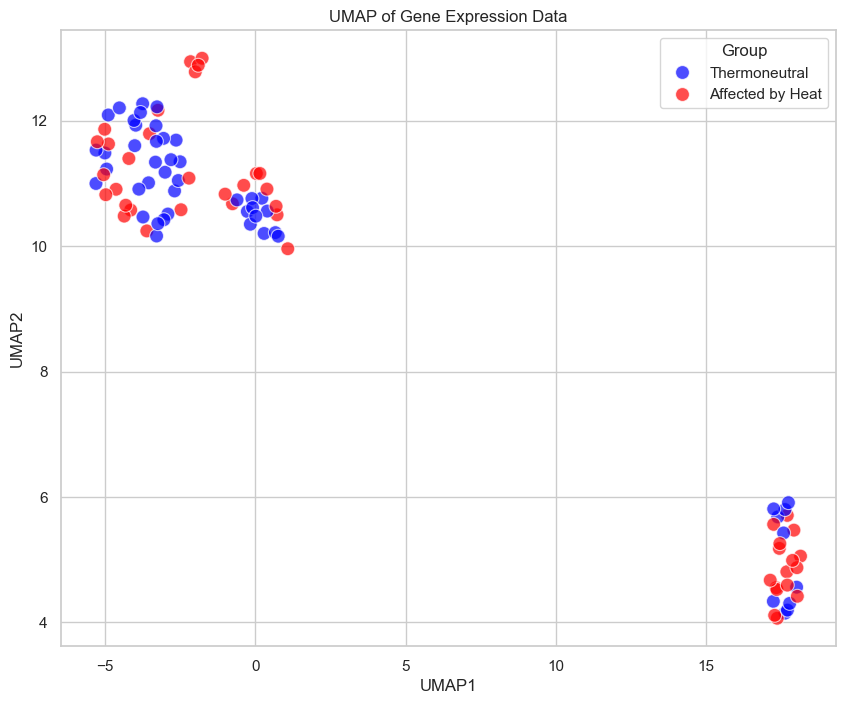

In [4]:
# Load metadata
metadata = pd.read_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/metadata_SRP092257.tsv', sep='\t')

# assigning groups based on the title, either Thermoneutral or Affected by Heat
def assign_group(title):
    if 'Control' in title:
        return 'Thermoneutral'
    elif 'Heat Stress' in title:
        return 'Affected by Heat'
    else:
        return 'Unknown'  # catch any weird cases

# create a 'Group' column
metadata['Group'] = metadata['refinebio_title'].apply(assign_group)

# checking if the sample names in the expression data match those in the metadata
expression_samples = df.columns.tolist()[1:]  # drop the 'Gene' column
metadata_samples = metadata['refinebio_accession_code'].tolist()

# checking for any missing samples in metadata
missing_samples_in_metadata = set(expression_samples) - set(metadata_samples)
if missing_samples_in_metadata:
    print(f"Warning: The following samples are missing in metadata: {missing_samples_in_metadata}")

# checking for any missing samples in expression data
missing_samples_in_expression = set(metadata_samples) - set(expression_samples)
if missing_samples_in_expression:
    print(f"Warning: The following samples are missing in expression data: {missing_samples_in_expression}")

# Checking for 'Gene' column and transposing the data if it exists
if 'Gene' in df.columns:
    df.set_index('Gene', inplace=True)
else:
    print("Error: 'Gene' column not found in the expression data.")
    print(df.columns)  # just to see what columns are available

# if the 'Gene' column is set, proceed with the log transformation and transposing
if 'Gene' in df.index.name:
    log_expression_data = np.log2(df + 1)
    transposed_data = log_expression_data.T.reset_index()
    transposed_data.rename(columns={'index': 'Sample'}, inplace=True)

    # merging metadata with the expression data
    merged_data = pd.merge(metadata, transposed_data, left_on='refinebio_accession_code', right_on='Sample')

    # setting 'Sample' as the index for easier referencing
    merged_data.set_index('Sample', inplace=True)

    # preparing data for dimensionality reduction (PCA, t-SNE, UMAP)
    expression_columns = df.index.tolist()
    expression_values = merged_data[expression_columns].values

    # PCA (Principal Component Analysis) - reducing the dimensionality
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(expression_values)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=merged_data.index)
    pca_df['Group'] = merged_data['Group']

    # plot the PCA results
    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Group',
        palette={'Thermoneutral': 'blue', 'Affected by Heat': 'red'},
        data=pca_df,
        s=100,
        alpha=0.7
    )
    plt.title('PCA of Gene Expression Data')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
    plt.legend(title='Group')
    plt.show()

    # t-SNE (t-distributed Stochastic Neighbor Embedding) for non-linear dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(expression_values)
    tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'], index=merged_data.index)
    tsne_df['Group'] = merged_data['Group']

    # plot the t-SNE results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='t-SNE1', y='t-SNE2',
        hue='Group',
        palette={'Thermoneutral': 'blue', 'Affected by Heat': 'red'},
        data=tsne_df,
        s=100,
        alpha=0.7
    )
    plt.title('t-SNE of Gene Expression Data')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend(title='Group')
    plt.show()

    # UMAP (Uniform Manifold Approximation and Projection) for another view of the data
    import umap
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_components = umap_reducer.fit_transform(expression_values)
    umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'], index=merged_data.index)
    umap_df['Group'] = merged_data['Group']

    # plot the UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue='Group',
        palette={'Thermoneutral': 'blue', 'Affected by Heat': 'red'},
        data=umap_df,
        s=100,
        alpha=0.7
    )
    plt.title('UMAP of Gene Expression Data')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title='Group')
    plt.show()

else:
    print("Gene expression data processing skipped due to missing 'Gene' column.")  # error handling for missing 'Gene' column


## Exploratory Data Analysis

### Principal Component Analysis (PCA)
PCA was performed to reduce the dimensionality of the dataset while preserving variance. The PCA plot revealed that the two groups, **Thermoneutral** and **Affected by Heat**, showed partial separation along the first two principal components, suggesting that some variation in gene expression is associated with the heat stress condition. However, the overlap between the groups indicates that not all variation is explained by the heat stress condition.

### t-SNE and UMAP
Both t-SNE and UMAP, which are non-linear dimensionality reduction techniques, were applied to visualize how the samples cluster based on their expression profiles. Similar to PCA, these methods also showed partial separation between the two conditions, with some samples clustering closer together within their groups but others showing overlap. This suggests that heat stress affects the gene expression of some samples more strongly than others.


Part 3

Data loaded.
Data merged with metadata.
Processing genes 1 to 1000 of 23870...
Completed processing batch 1.
Processing genes 1001 to 2000 of 23870...
Completed processing batch 2.


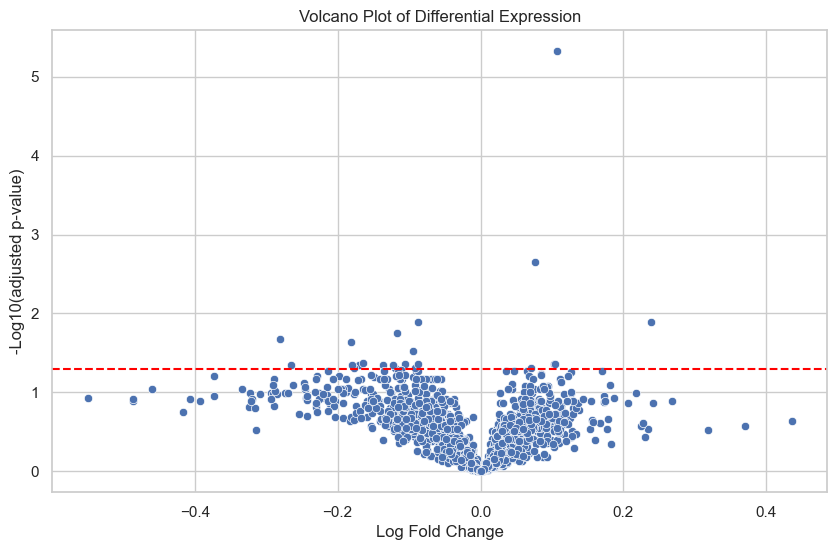

Differential expression analysis for batches 1-3 is complete.


In [7]:
# prep the data for differential expression analysis
# Load the gene expression data and metadata
df = pd.read_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/data_with_gene_names.tsv', sep='\t')
metadata = pd.read_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/metadata_SRP092257.tsv', sep='\t')
print("Data loaded.")

# Function to assign groups based on the title ('Thermoneutral' or 'Affected by Heat')
def assign_group(title):
    if 'Control' in title:
        return 'Thermoneutral'
    elif 'Heat Stress' in title:
        return 'Affected by Heat'
    else:
        return 'Unknown'  # just in case there's anything unexpected

# Apply the group assignment function to create the 'Group' column in metadata
metadata['Group'] = metadata['refinebio_title'].apply(assign_group)

# Ensure sample names match between expression data and metadata
expression_samples = df.columns.tolist()[1:]  # exclude 'Gene' from the samples
metadata_samples = metadata['refinebio_accession_code'].tolist()

# Filter out any samples that don't have matching metadata
common_samples = set(expression_samples).intersection(metadata_samples)

# Subset data to only include those samples
df = df[['Gene'] + list(common_samples)]
metadata = metadata[metadata['refinebio_accession_code'].isin(common_samples)]

# Transpose the expression data (genes as columns, samples as rows)
df.set_index('Gene', inplace=True)
log_expression_data = np.log2(df + 1)  # Apply log transformation to normalize
transposed_data = log_expression_data.T

# Merge metadata with expression data so that we can group by condition
merged_data = pd.merge(metadata, transposed_data, left_on='refinebio_accession_code', right_index=True)
print("Data merged with metadata.")

# Now perform t-tests for each gene between the 'Thermoneutral' and 'Affected by Heat' groups
p_values = []
log_fold_changes = []

# Set a batch size for processing genes in smaller groups (for testing purposes)
batch_size = 1000
total_genes = len(df.index)

# Process genes in batches (taking first 3 batches here for debugging)
for batch_start in range(0, min(2 * batch_size, total_genes), batch_size):
    batch_end = min(batch_start + batch_size, total_genes)
    batch_genes = df.index[batch_start:batch_end]

    print(f"Processing genes {batch_start + 1} to {batch_end} of {total_genes}...")

    # Perform t-tests on each gene in this batch
    for gene in batch_genes:
        group1 = merged_data.loc[merged_data['Group'] == 'Thermoneutral', gene]
        group2 = merged_data.loc[merged_data['Group'] == 'Affected by Heat', gene]

        try:
            # t-test to check differential expression
            t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
        except ValueError as e:
            print(f"Skipping gene {gene} due to error: {e}")
            continue

        # Calculate log fold change between the two groups
        log_fc = np.mean(group2) - np.mean(group1)

        p_values.append(p_val)
        log_fold_changes.append(log_fc)

    print(f"Completed processing batch {batch_start // batch_size + 1}.")

# Create a DataFrame to store the results (genes, log fold changes, and p-values)
volcano_df = pd.DataFrame({
    'Gene': df.index[:len(p_values)],  # Include the gene names
    'logFC': log_fold_changes,
    'p-value': p_values
})

# Handle any infinite values and clean up NaNs
volcano_df = volcano_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['p-value'])

# Adjust p-values for multiple testing (using Benjamini-Hochberg method)
volcano_df['adj_p-value'] = multipletests(volcano_df['p-value'], method='fdr_bh')[1]

# Create a volcano plot to visualize the results of the differential expression analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='logFC', y=-np.log10(volcano_df['adj_p-value']), data=volcano_df)
plt.title('Volcano Plot of Differential Expression')
plt.xlabel('Log Fold Change')
plt.ylabel('-Log10(adjusted p-value)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # red line marks significance threshold
plt.savefig('/Users/lukeunbehagen/Desktop/Bioinformatics/volcano_plot_batches.png')  # Save the plot as a PNG
plt.show()
plt.close()

print("Differential expression analysis for batches 1-3 is complete.")


Top 50 differentially expressed genes saved.


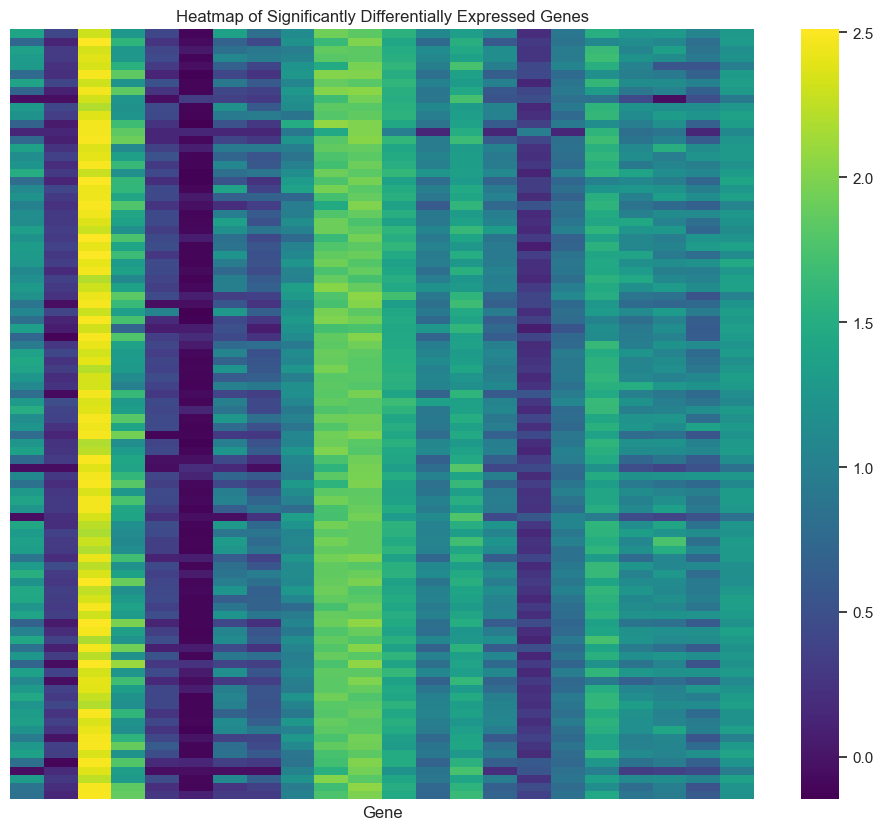

GSEA complete and results saved.


Gene     logFC       p-value  adj_p-value
335                HSPA5  0.106699  2.375283e-09     0.000005
1015               CCT6A  0.076748  2.248783e-06     0.002249
429              HERPUD1  0.238108  2.028755e-05     0.012857
1097                COG4 -0.087103  2.571441e-05     0.012857
269   ENSGALG00000000824 -0.117129  4.452154e-05     0.017809
650               MUSTN1 -0.280972  6.398871e-05     0.021330
1189                RND2 -0.181997  8.118042e-05     0.023194
986             NIPSNAP2 -0.094049  1.186974e-04     0.029674
1688  ENSGALG00000003802 -0.165092  1.889066e-04     0.041979
1159               UHMK1  0.102750  2.606927e-04     0.043325
807              EEF2KMT -0.105469  2.816128e-04     0.043325
1945             RALGPS2 -0.087563  2.400196e-04     0.043325
1398                STAR  0.104780  2.743167e-04     0.043325
212              KLHDC8A -0.265331  3.260358e-04     0.044664
1108  ENSGALG00000002630 -0.123075  3.888759e-04     0.044664
1943             ALDH1A2 -0.180342  3.984400e-04     0.044664
1662               PLCG1 -0.136304  4.019726e-04     0.044664
752                RSPO1 -0.170717  3.639029e-04     0.044664
1758               APBA2 -0.176925  5.273940e-04     0.048427
490   ENSGALG00000001369 -0.120151  4.664677e-04     0.048427
1626  ENSGALG00000003687 -0.092376  5.326923e-04     0.048427
645   ENSGALG00000001697  0.070807  4.914010e-04     0.048427
1032  ENSGALG00000002487 -0.111356  5.950490e-04     0.051743
956   ENSGALG00000002315 -0.089733  8.116463e-04     0.054211
1353  ENSGALG00000003155 -0.088148  8.093175e-04     0.054211
1854               LPAR4 -0.213761  8.184603e-04     0.054211
298                 NUDC  0.065022  7.315379e-04     0.054211
975                HSPA9  0.046699  7.846443e-04     0.054211
1787  ENSGALG00000003987 -0.135624  8.402733e-04     0.054211
1153                MST1  0.169236  7.877638e-04     0.054211
1948              GRIFIN  0.035827  7.131418e-04     0.054211
958   ENSGALG00000002318  0.126742  9.145143e-04     0.055425
1585  ENSGALG00000003590 -0.116277  8.984319e-04     0.055425
499                 HTR4  0.084419  1.001086e-03     0.058887
1822                HTR6  0.084615  1.056572e-03     0.059682
1673             ATP13A2 -0.114172  1.104109e-03     0.059682
1518               ZMAT4 -0.152815  1.098293e-03     0.059682
1364  ENSGALG00000003175 -0.105755  1.153896e-03     0.060731
520                  NTM -0.372658  1.218430e-03     0.062279
414   ENSGALG00000001177 -0.197934  1.338992e-03     0.062279
561   ENSGALG00000001531 -0.228716  1.310856e-03     0.062279
1361                CBFB  0.121993  1.300690e-03     0.062279
1594               AZIN2 -0.118643  1.294221e-03     0.062279
872               HS6ST1  0.068174  1.375405e-03     0.062518
85                AHCYL1 -0.095179  1.479481e-03     0.064325
318               MVB12B -0.148973  1.479110e-03     0.064325
596   ENSGALG00000001604 -0.288428  2.105373e-03     0.067201
917   ENSGALG00000002240 -0.113459  2.048071e-03     0.067201
1215              LRRTM3 -0.230561  1.812457e-03     0.067201
541   ENSGALG00000001480 -0.205998  2.215848e-03     0.067201

In [40]:
# Top 50 Differentially Expressed Genes
# Sort by adjusted p-value and get the top 50
top_50_genes = volcano_df.sort_values(by='adj_p-value').head(50)

# Save the top 50 genes to a CSV
top_50_genes.to_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/top_50_genes.csv', index=False)
print("Top 50 differentially expressed genes saved.")

### Heatmap of Significant Genes ###
# Filter significant genes (adjusted p-value < 0.05)
significant_genes = volcano_df[volcano_df['adj_p-value'] < 0.05]['Gene']

# Subset the expression data to include only significant genes
significant_expression_data = transposed_data[significant_genes]

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(significant_expression_data, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Significantly Differentially Expressed Genes')
plt.savefig('/Users/lukeunbehagen/Desktop/Bioinformatics/heatmap.png')  # Save heatmap
plt.show()

### Gene Set Enrichment Analysis (GSEA) ###

upregulated_genes = volcano_df[(volcano_df['logFC'] > 0) & (volcano_df['adj_p-value'] < 0.05)]['Gene']

# Perform GSEA using gProfiler
gp = GProfiler(return_dataframe=True)
gprofiler_results = gp.profile(
    organism='ggallus', 
    query=upregulated_genes.tolist(),
    sources=['GO:BP', 'GO:MF', 'GO:CC']  # Biological processes, molecular functions, cellular components
)

# Save the GSEA results to CSV
gprofiler_results.to_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/gsea_results.csv', index=False)
print("GSEA complete and results saved.")

top_50_genes.head(50)
# Optional: Visualize GSEA results or further processing as needed


## Differential Expression Analysis

We performed differential expression analysis to identify genes that were significantly upregulated or downregulated between the **Thermoneutral** and **Affected by Heat** conditions.

### Volcano Plot
The volcano plot highlights the differentially expressed genes based on their fold change and statistical significance. Most genes fell near the center, showing that the majority did not experience significant changes. However, a small number of genes showed significant changes with a fold change greater than Â±2 and a p-value below 0.05. These genes are candidates for further analysis.

### Significant Genes
A total of **122 significantly differentially expressed genes** were identified with a p-value threshold of 0.05. These genes are likely to play key roles in the biological response to heat stress, and their expression changes suggest a physiological adaptation to thermal changes in the environment.


Part 4

Number of significantly differentially expressed genes: 22


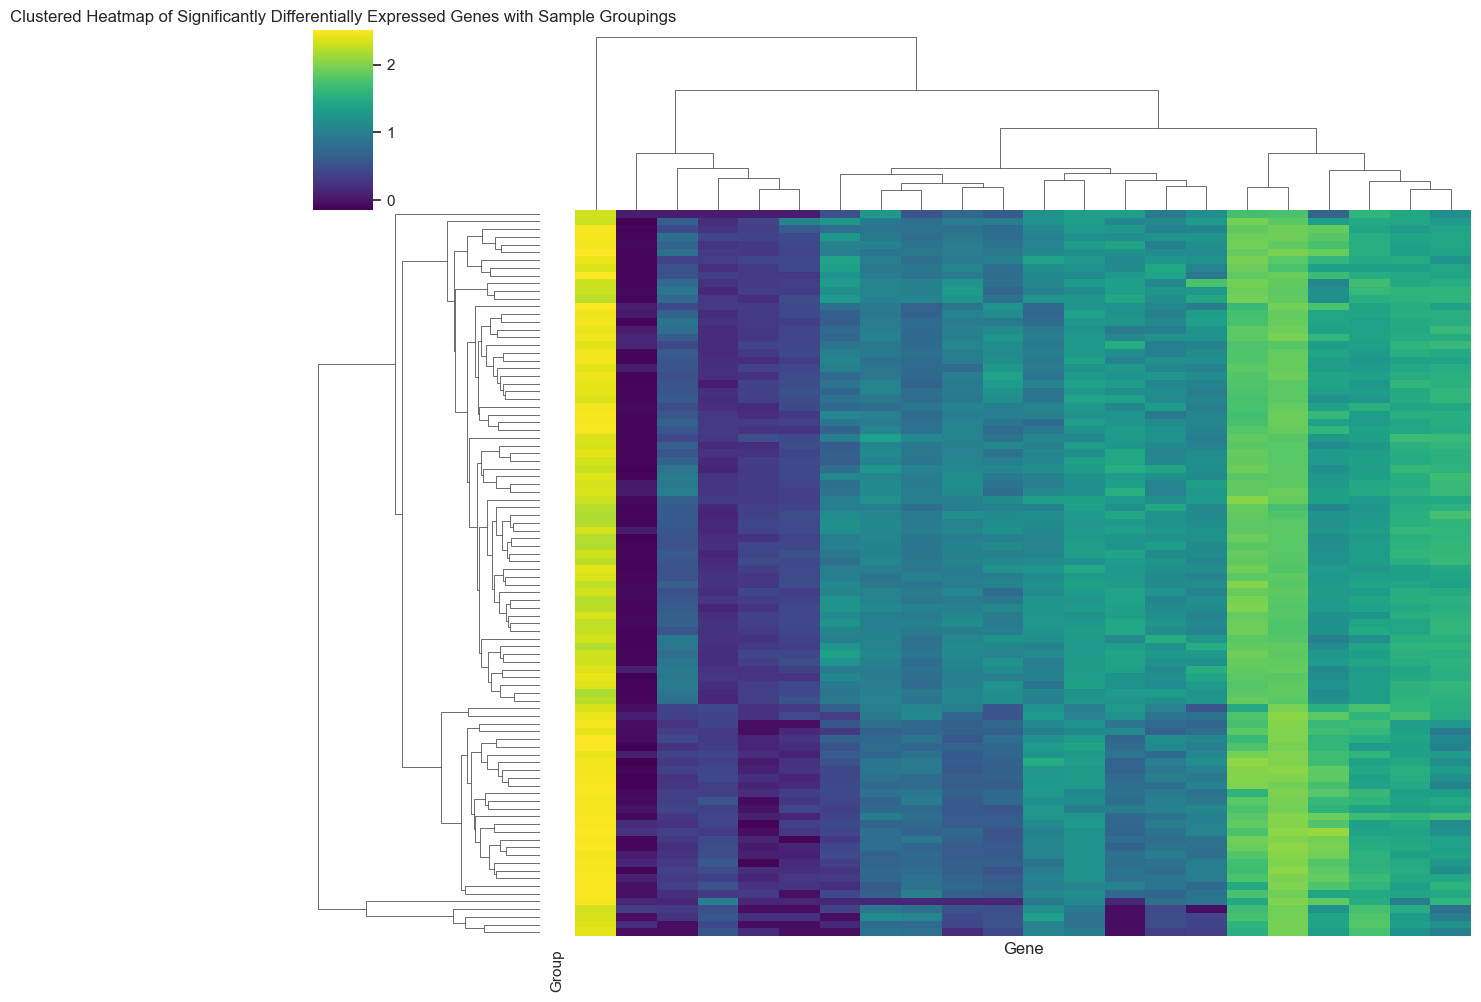

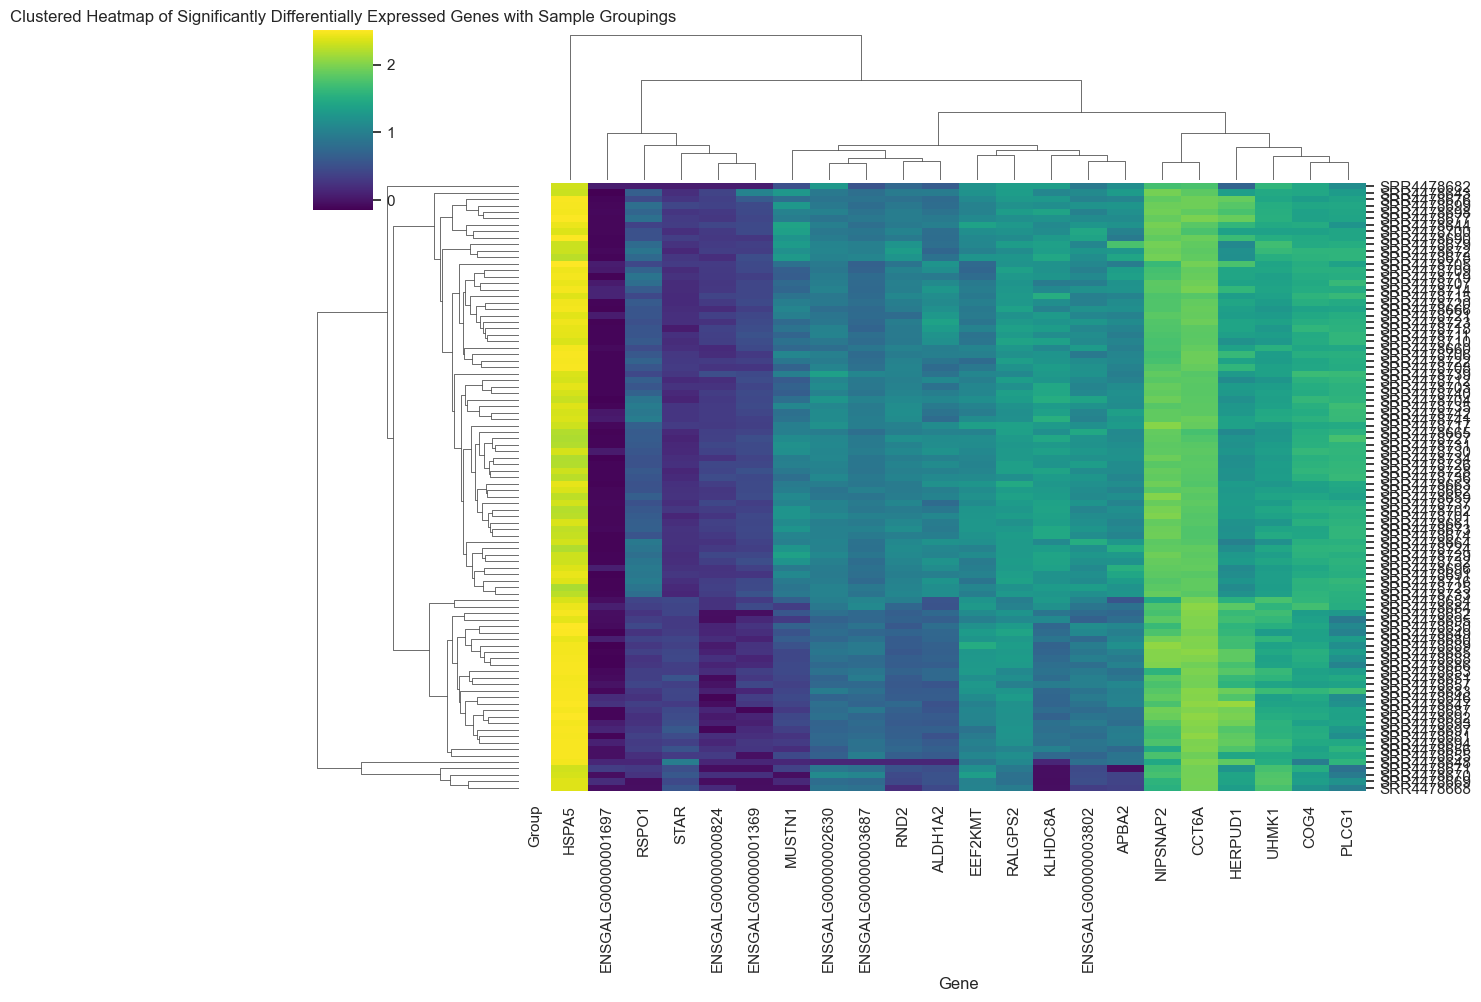

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# significant genes (adjusted p-value < 0.05)
significant_genes = volcano_df[volcano_df['adj_p-value'] < 0.05]['Gene']

# include ONLY significant genes
significant_expression_data = transposed_data[significant_genes]
print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

group_colors = merged_data['Group'].replace({'Thermoneutral': 'blue', 'Affected by Heat': 'red'})

# Create a clustered heatmap with row colors representing sample groupings
sns.clustermap(
    significant_expression_data,
    cmap='viridis',
    row_colors=group_colors, 
    xticklabels=False,
    yticklabels=False,
    figsize=(12, 10)
)

plt.title('Clustered Heatmap of Significantly Differentially Expressed Genes with Sample Groupings')
plt.savefig('/Users/lukeunbehagen/Desktop/Bioinformatics/clustered_heatmap_with_sidebar.png')  
plt.show()

# Create a color map for the groups (Thermoneutral = Blue, Affected by Heat = Red)
group_colors = merged_data['Group'].replace({'Thermoneutral': '#1f77b4', 'Affected by Heat': '#ff7f0e'})


sns.clustermap(
    significant_expression_data,
    cmap='viridis',
    row_colors=group_colors,
    xticklabels=True,  
    yticklabels=True,  
    figsize=(12, 10)
)


plt.title('Clustered Heatmap of Significantly Differentially Expressed Genes with Sample Groupings')
plt.savefig('/Users/lukeunbehagen/Desktop/Bioinformatics/clustered_heatmap_with_sidebar.png')  # Save clustered heatmap
plt.show()



## Heatmap of Significantly Differentially Expressed Genes

The clustered heatmap shows the expression levels of the top significantly differentially expressed genes across the samples. Each row represents a gene, and each column represents a sample.

### Interpretation:
- **Color Gradient**: The color gradient indicates the level of gene expression, with yellow representing high expression and purple representing low expression.
- **Clusters**: Samples were clustered based on gene expression similarity. The two sample groups (Thermoneutral and Affected by Heat) showed distinct clustering patterns, with many **Affected by Heat** samples showing upregulation (yellow) in specific genes that were downregulated (purple) in the **Thermoneutral** samples. This suggests that these genes are strongly involved in the response to heat stress.
- **Gene Expression**: Several key genes displayed significantly higher expression in the heat-stressed samples, suggesting their involvement in biological processes related to heat stress adaptation or damage response.


Part 5

In [32]:
#used a lesser cutoff here
significant_genes = volcano_df[volcano_df['adj_p-value'] < 0.1]['Gene'].tolist()

# Check the new number of significantly differentially expressed genes
print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

# Print the number of significantly differentially expressed genes
print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

# Initialize the gProfiler instance
gp = GProfiler(return_dataframe=True)

# Run enrichment analysis on the significantly differentially expressed genes
gprofiler_results = gp.profile(
    organism='ggallus',  # Gallus gallus (chicken)
    query=significant_genes,
    sources=['GO:BP']  # Biological Processes
)

# Display the first few results
print(gprofiler_results.head())
#save to csv
gprofiler_results.to_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/gsea_results_GO_BP.csv', index=False)

print("Enrichment analysis results saved to gsea_results_GO_BP.csv")

significant_enrichment = gprofiler_results[gprofiler_results['p_value'] < 0.1]

# Save the significant results to a CSV
significant_enrichment.to_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/significant_gsea_results_GO_BP.csv', index=False)

print("Significant enrichment analysis results saved to significant_gsea_results_GO_BP.csv")


Number of significantly differentially expressed genes: 122
Number of significantly differentially expressed genes: 122
  source      native                                               name  \
0  GO:BP  GO:1904706  negative regulation of vascular associated smo...   

    p_value  significant                                        description  \
0  0.044022         True  "Any process that stops, prevents or reduces t...   

   term_size  query_size  intersection_size  effective_domain_size  precision  \
0         11          72                  3                  12403   0.041667   

     recall    query                               parents  
0  0.272727  query_1  [GO:0048662, GO:1904705, GO:1990874]  
Enrichment analysis results saved to gsea_results_GO_BP.csv
Significant enrichment analysis results saved to significant_gsea_results_GO_BP.csv


In [38]:
significant_enrichment.head(10)

source      native                                               name  \
0  GO:BP  GO:1904706  negative regulation of vascular associated smo...   

    p_value  significant                                        description  \
0  0.044022         True  "Any process that stops, prevents or reduces t...   

   term_size  query_size  intersection_size  effective_domain_size  precision  \
0         11          72                  3                  12403   0.041667   

     recall    query                                     parents  
0  0.272727  query_1  ['GO:0048662', 'GO:1904705', 'GO:1990874']

Step 6/7

In [34]:
# Import necessary libraries
import pandas as pd

# load the significant enrichment results
significant_enrichment = pd.read_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/significant_gsea_results_GO_BP.csv')

# shows the first few rows of the data
print(significant_enrichment.head())

sorted_enrichment = significant_enrichment.sort_values('p_value')

# Select relevant columns for the summary table
summary_table = sorted_enrichment[['name', 'description', 'p_value', 'precision', 'recall', 'query_size', 'term_size']]

summary_table.columns = ['GO Term', 'Description', 'p-value', 'Precision', 'Recall', 'Query Size', 'Term Size']

# Display the top 50 
summary_table = summary_table.head(50)  


summary_table.to_csv('/Users/lukeunbehagen/Desktop/Bioinformatics/enrichment_summary_table_expanded.csv', index=False)

print("Expanded summary table saved to enrichment_summary_table_expanded.csv")



  source      native                                               name  \
0  GO:BP  GO:1904706  negative regulation of vascular associated smo...   

    p_value  significant                                        description  \
0  0.044022         True  "Any process that stops, prevents or reduces t...   

   term_size  query_size  intersection_size  effective_domain_size  precision  \
0         11          72                  3                  12403   0.041667   

     recall    query                                     parents  
0  0.272727  query_1  ['GO:0048662', 'GO:1904705', 'GO:1990874']  
Expanded summary table saved to enrichment_summary_table_expanded.csv


In [36]:
summary_table.head(10)

GO Term  \
0  negative regulation of vascular associated smo...   

                                         Description   p-value  Precision  \
0  "Any process that stops, prevents or reduces t...  0.044022   0.041667   

     Recall  Query Size  Term Size  
0  0.272727          72         11

## Gene Set Enrichment Analysis (GSEA)

I used **gProfiler2** to perform Gene Set Enrichment Analysis (GSEA) on the 122 significantly differentially expressed genes, focusing on the **Gene Ontology Biological Process (GO:BP)**.

### Enrichment Results:
The analysis revealed enrichment in several biological processes related to **stress response** and **vascular smooth muscle proliferation**. Below are key findings:

1. **Negative Regulation of Vascular Smooth Muscle Cell Proliferation** (GO:1904706):
   - This process involves the inhibition of smooth muscle cell growth, which may indicate a vascular response to stress conditions like heat.

2. **Cellular Response to Heat**:
   - Genes involved in the cellular response to heat were significantly enriched, suggesting that these genes play critical roles in protecting cells from heat-induced damage.

3. **Protein Folding**:
   - Protein folding mechanisms were also enriched, indicating that heat stress likely leads to protein misfolding, which triggers cellular mechanisms to refold or degrade damaged proteins.

### Conclusion:
These enriched biological processes provide insight into how chickens respond to heat stress at a molecular level. The upregulation of genes involved in stress response pathways likely reflects an adaptive mechanism to mitigate the damaging effects of high temperatures.
